In [2]:
%cd /work/adapting-CLIP-VGPs/
import torch
from tqdm import tqdm
from collections import OrderedDict


def val(model, heatmap_loader, checkpoint_path, gpu, output_type='sigmoid'):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    GPU = gpu
    new_state_dict = OrderedDict()
    for k, v in checkpoint['model_state_dict'].items():
        prefix = 'module.'
        name = k[len(prefix):]  # remove `module.` prefix
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    model.to(GPU)
    model.eval()

    test_results = []

    with torch.no_grad():
        for batch in tqdm(heatmap_loader):
            image_paths = batch['img_idx']
            phrase_pairs = [list(phrase_pair) for phrase_pair in zip(batch['phrases'][0],batch['phrases'][1])]
            left_text_ft = batch['left_text_emb']
            right_text_ft = batch['right_text_emb']
            left_heatmaps = batch['left_heatmap']
            right_heatmaps = batch['right_heatmap']
            labels = batch['label']
            
            left_heatmaps = left_heatmaps.unsqueeze(1).to(GPU)
            right_heatmaps = right_heatmaps.unsqueeze(1).to(GPU)
            left_text_ft = left_text_ft.squeeze(1).float().to(GPU)
            right_text_ft = right_text_ft.squeeze(1).float().to(GPU)
            label_tensor = labels.float().unsqueeze(1).to(GPU)
            
            outputs = model(left_heatmaps, right_heatmaps, left_text_ft, right_text_ft)
            # loss = criterion(outputs, label_tensor)
            if output_type == 'sigmoid':
                preds = (outputs > 0.5).float()
            elif output_type == 'softmax':
                _, preds = outputs.max(dim=1)
                preds = preds.unsqueeze(1)
            for i in range(len(image_paths)):
                test_results.append([image_paths[i], phrase_pairs[i], outputs[i].item(), preds[i].item(), labels[i].item()])      
    return test_results    

/work/adapting-CLIP-VGPs


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

def visualize_val(test_results):
    # val_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/siamese_test_results.csv')
    pred = test_results['3']
    gt = test_results['4']

    # Replace actual_labels and predicted_labels with your own data
    cm = confusion_matrix(gt, pred)

    # Define class labels
    class_labels = ['Negative', 'Positive']

    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    from sklearn.metrics import precision_score, recall_score, f1_score

    # Calculate precision
    precision = precision_score(gt, pred)

    # Calculate recall
    recall = recall_score(gt, pred)

    # Calculate F1 score
    f1 = f1_score(gt, pred)

    # Calculate accuracy
    acc = sum(x==y for x,y in zip(gt,pred))/len(gt)

    print(f'Accuracy: {acc}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')

In [5]:
from utils.heatmap_data import VGPsHeatmapsDataset
from torch.utils.data import DataLoader

heatmap_dataset = VGPsHeatmapsDataset(split="test")
batch_size = 100

heatmap_loader = DataLoader(
    dataset=heatmap_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [23]:
from models.text_heatmap_sigmoid import TextHeatmapSigmoidClassifier
model = TextHeatmapSigmoidClassifier(heatmap_only=False, gating=True, use_dropout=True)
checkpoint_path = '/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/07_checkpoint5.pt'

In [24]:
test_results = val(model, heatmap_loader,checkpoint_path)

100%|██████████| 813/813 [06:39<00:00,  2.04it/s]


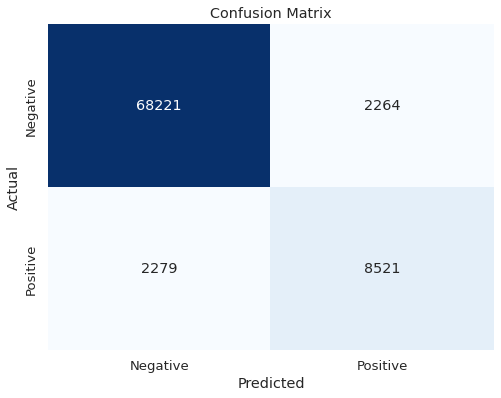

Accuracy: 0.944110229439626
Precision: 0.7900788131664349
Recall: 0.7889814814814815
F1 Score: 0.7895297660412324


In [25]:
visualize_val(test_results)

In [31]:
model = TextHeatmapSigmoidClassifier(heatmap_only=False, gating=True, use_dropout=True)
checkpoint_path = '/work/adapting-CLIP-VGPs/checkpoints/heatmap only/04_checkpoint5.pt'

In [32]:
test_results = val(model, heatmap_loader,checkpoint_path)

100%|██████████| 813/813 [06:01<00:00,  2.25it/s]


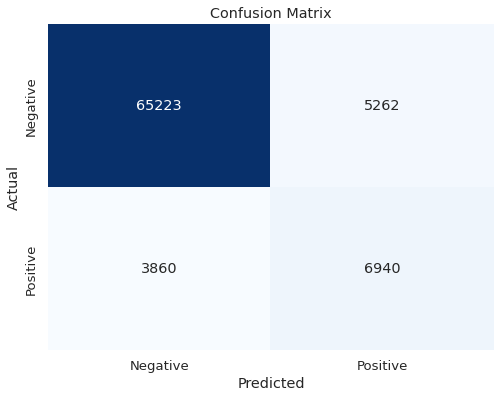

Accuracy: 0.8877775727378975
Precision: 0.5687592198000327
Recall: 0.6425925925925926
F1 Score: 0.6034257890618208


In [33]:
visualize_val(test_results)

# Heatmap only

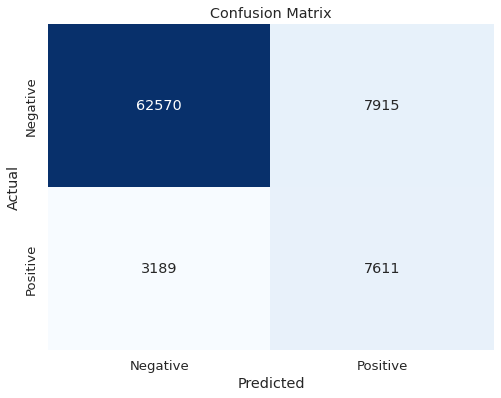

Accuracy: 0.8633942301777696
Precision: 0.49020997037227876
Recall: 0.7047222222222222
F1 Score: 0.5782116538782952


In [6]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/heatmap only/20_checkpoint3.csv')
visualize_val(test_results)


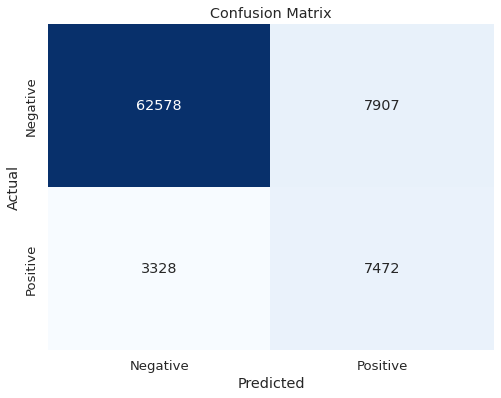

Accuracy: 0.8617826167189518
Precision: 0.48585733792834385
Recall: 0.6918518518518518
F1 Score: 0.5708392222773979


In [8]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/heatmap only/21_checkpoint4.csv')
visualize_val(test_results)


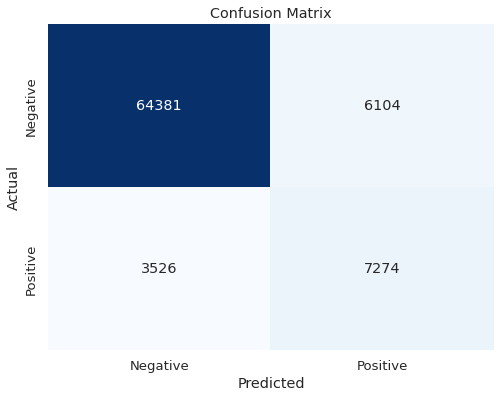

Accuracy: 0.881527957187673
Precision: 0.5437285094931978
Recall: 0.6735185185185185
F1 Score: 0.6017040284556208


In [4]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/heatmap only/22_checkpoint9.csv')
visualize_val(test_results)

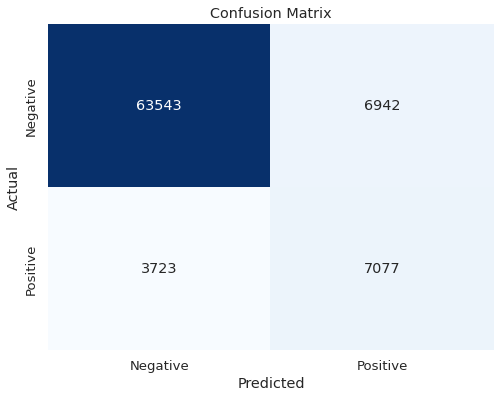

Accuracy: 0.8687949806237313
Precision: 0.5048148940723304
Recall: 0.6552777777777777
F1 Score: 0.570288891575003


In [5]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/heatmap only/23_checkpoint12.csv')
visualize_val(test_results)


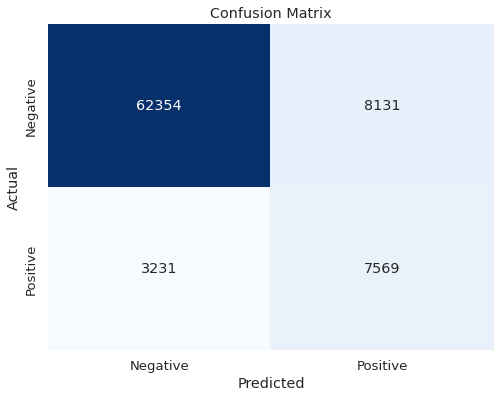

Accuracy: 0.8602202128313957
Precision: 0.4821019108280255
Recall: 0.7008333333333333
F1 Score: 0.5712452830188679


In [6]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/heatmap only/24_checkpoint5.csv')
visualize_val(test_results)


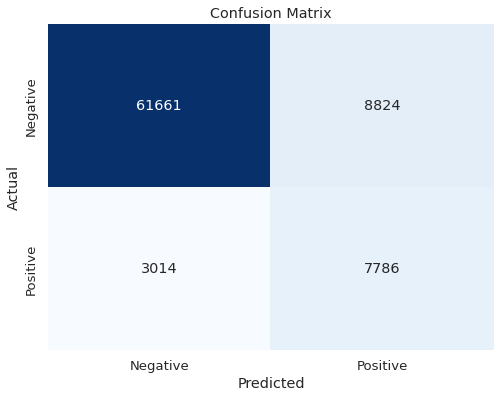

Accuracy: 0.8543642738512641
Precision: 0.4687537627934979
Recall: 0.720925925925926
F1 Score: 0.5681138270704122


In [8]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/heatmap only/25_checkpoint4.csv')
visualize_val(test_results)


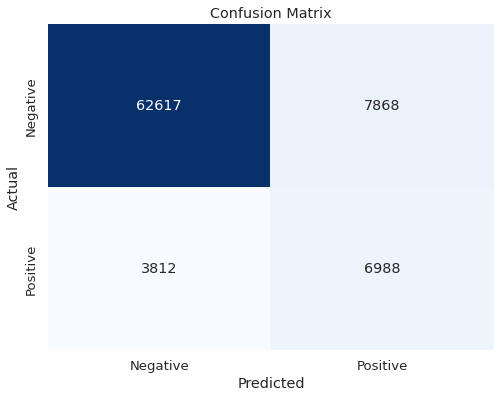

Accuracy: 0.8563080519160977
Precision: 0.47038233710285404
Recall: 0.6470370370370371
F1 Score: 0.5447458684128469


In [9]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/heatmap only/26_checkpoint35.csv')
visualize_val(test_results)


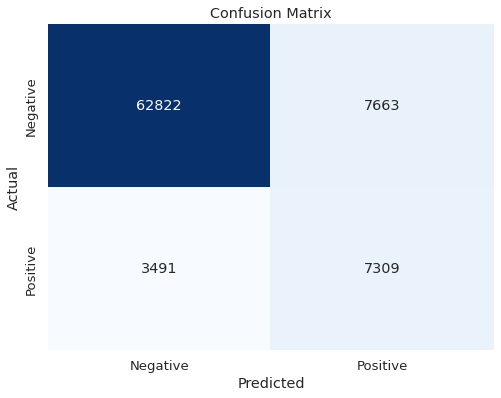

Accuracy: 0.8627791105369994
Precision: 0.48817793213999466
Recall: 0.6767592592592593
F1 Score: 0.5672047182989292


In [10]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/heatmap only/27_checkpoint25.csv')
visualize_val(test_results)


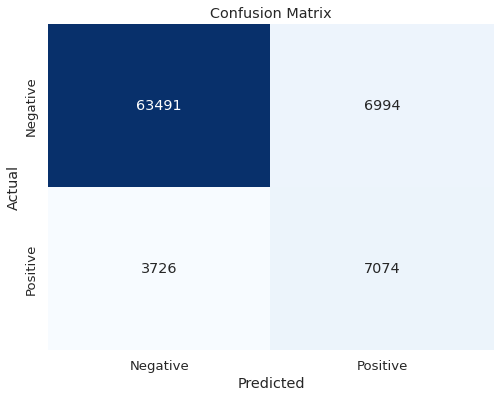

Accuracy: 0.8681183490188842
Precision: 0.5028433323855559
Recall: 0.655
F1 Score: 0.5689239182885637


In [12]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/heatmap only/28_checkpoint24.csv')
visualize_val(test_results)


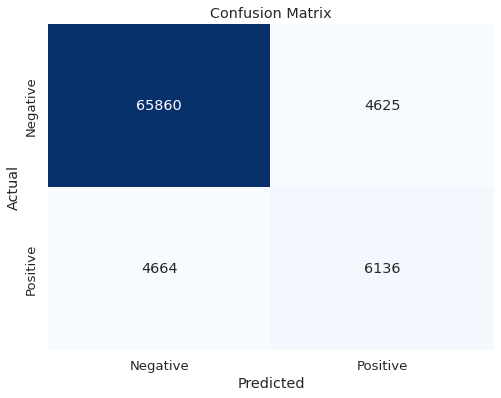

Accuracy: 0.8857230731377252
Precision: 0.5702072298113559
Recall: 0.5681481481481482
F1 Score: 0.569175826724178


In [12]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/30_checkpoint3.csv')
visualize_val(test_results)


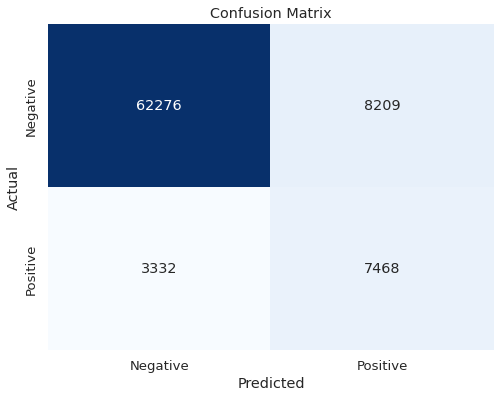

Accuracy: 0.8580180845174387
Precision: 0.47636665178286663
Recall: 0.6914814814814815
F1 Score: 0.5641122483665066


In [10]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/heatmap only/31_checkpoint4.csv')
visualize_val(test_results)


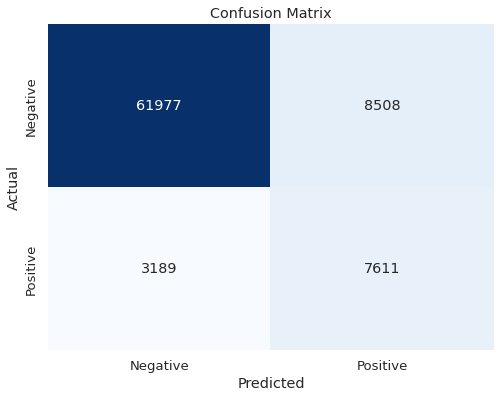

Accuracy: 0.8560989112382358
Precision: 0.47217569328122094
Recall: 0.7047222222222222
F1 Score: 0.5654742003789146


In [9]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/heatmap only/32_checkpoint2.csv')
visualize_val(test_results)


# Text heatmap

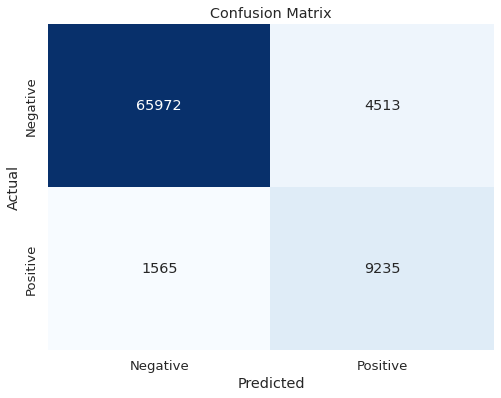

Accuracy: 0.9252260564679831
Precision: 0.6717340704102415
Recall: 0.8550925925925926
F1 Score: 0.7524034544565747


In [9]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/20_checkpoint4.csv')
visualize_val(test_results)


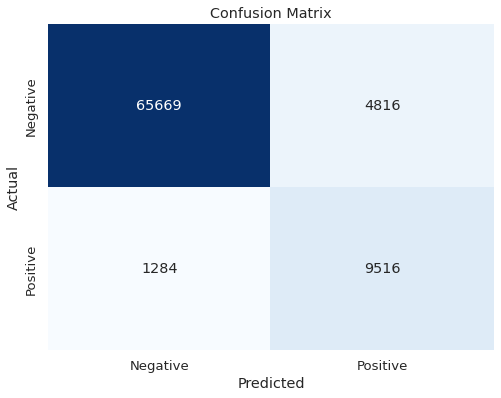

Accuracy: 0.9249554038260441
Precision: 0.6639687412782584
Recall: 0.8811111111111111
F1 Score: 0.7572815533980582


In [10]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/21_checkpoint4.csv')
visualize_val(test_results)

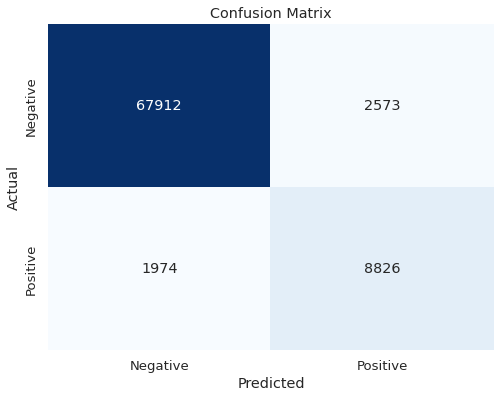

Accuracy: 0.9440610198683644
Precision: 0.7742784454776734
Recall: 0.8172222222222222
F1 Score: 0.7951709536465605


In [11]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/22_checkpoint19.csv')
visualize_val(test_results)

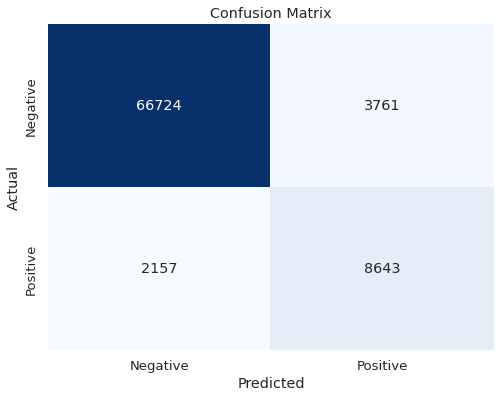

Accuracy: 0.9271944393184475
Precision: 0.6967913576265721
Recall: 0.8002777777777778
F1 Score: 0.7449577659024307


In [3]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/23_checkpoint20.csv')
visualize_val(test_results)

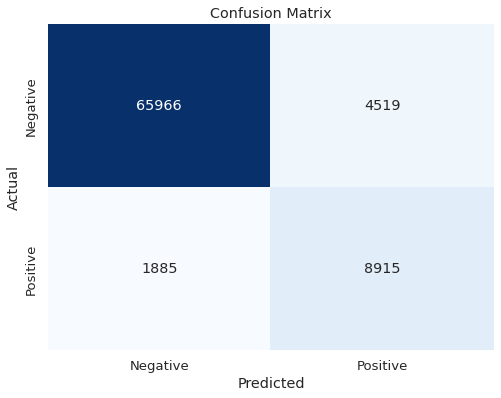

Accuracy: 0.9212154764101618
Precision: 0.6636147089474468
Recall: 0.825462962962963
F1 Score: 0.7357431707518363


In [3]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/24_checkpoint5.csv')
visualize_val(test_results)

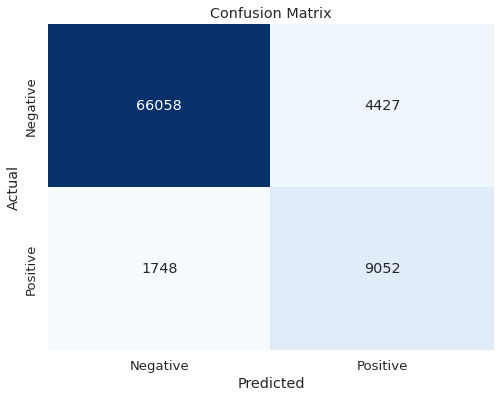

Accuracy: 0.9240327243648889
Precision: 0.6715631723421619
Recall: 0.8381481481481482
F1 Score: 0.7456649779644962


In [4]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/25_checkpoint5.csv')
visualize_val(test_results)

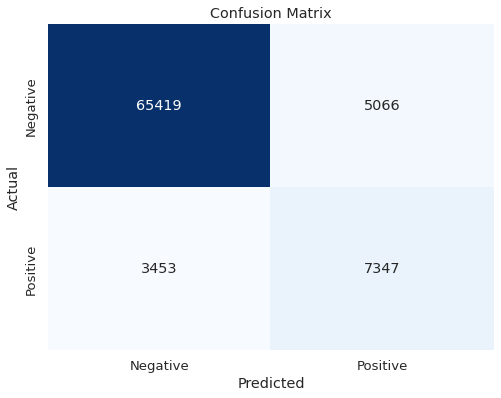

Accuracy: 0.8951959156055853
Precision: 0.591879481189076
Recall: 0.6802777777777778
F1 Score: 0.6330073665618403


In [5]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/26_checkpoint35.csv')
visualize_val(test_results)

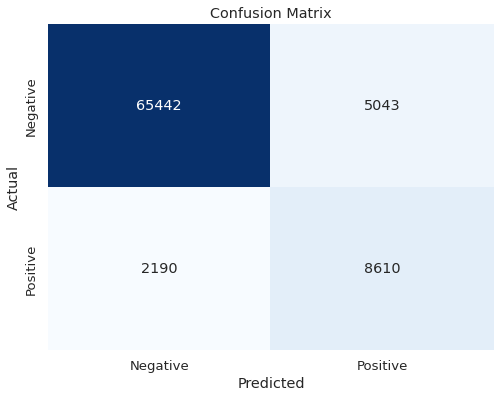

Accuracy: 0.9110167927661931
Precision: 0.6306306306306306
Recall: 0.7972222222222223
F1 Score: 0.7042080726291252


In [6]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/27_checkpoint25.csv')
visualize_val(test_results)

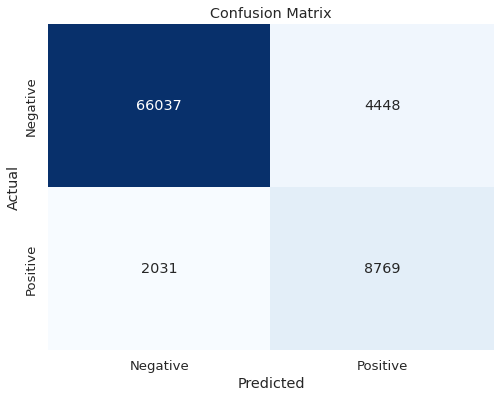

Accuracy: 0.9202927969490066
Precision: 0.6634637209654233
Recall: 0.8119444444444445
F1 Score: 0.7302327518008077


In [7]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/28_checkpoint25.csv')
visualize_val(test_results)

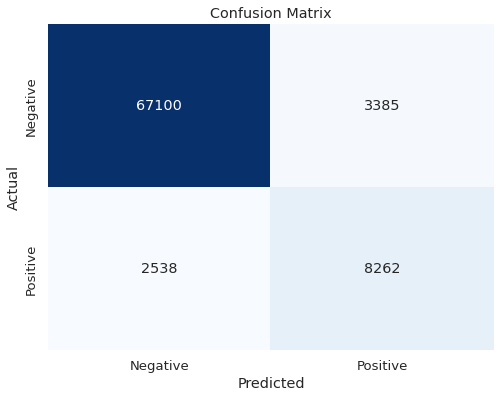

Accuracy: 0.9271329273543705
Precision: 0.7093672190263587
Recall: 0.765
F1 Score: 0.736134004544037


In [4]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/30_checkpoint4None.csv')
visualize_val(test_results)

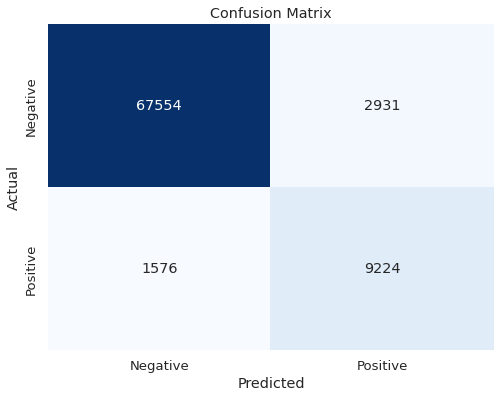

Accuracy: 0.9445531155809805
Precision: 0.7588646647470176
Recall: 0.8540740740740741
F1 Score: 0.803659333478545


In [4]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/31_checkpoint4.csv')
visualize_val(test_results)

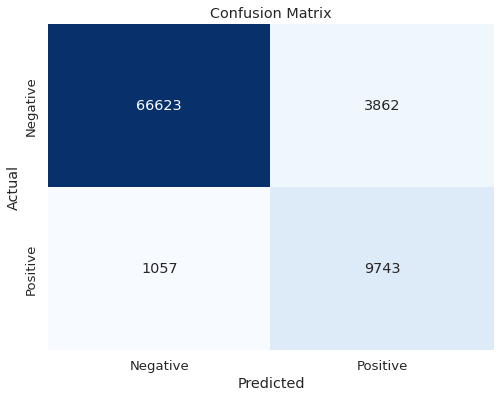

Accuracy: 0.9394845297410346
Precision: 0.7161337743476663
Recall: 0.9021296296296296
F1 Score: 0.7984429420200779


In [5]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/32_checkpoint3.csv')
visualize_val(test_results)

# Eval demo

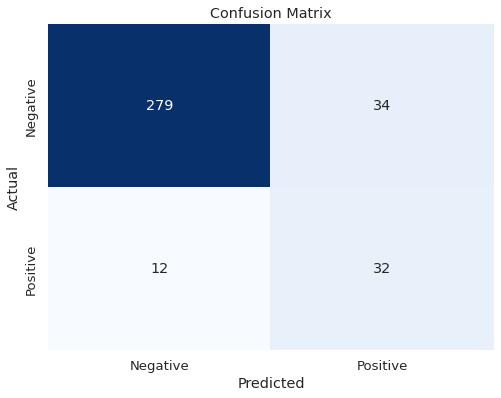

Accuracy: 0.8711484593837535
Precision: 0.48484848484848486
Recall: 0.7272727272727273
F1 Score: 0.5818181818181818


In [8]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/heatmap only/20_checkpoint3_357samples.csv')
visualize_val(test_results)

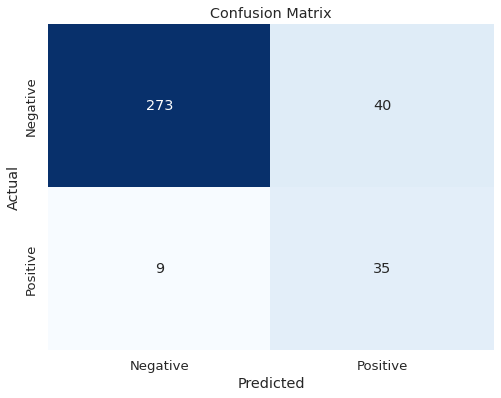

Accuracy: 0.8627450980392157
Precision: 0.4666666666666667
Recall: 0.7954545454545454
F1 Score: 0.5882352941176471


In [9]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/heatmap only/21_checkpoint4_357samples.csv')
visualize_val(test_results)

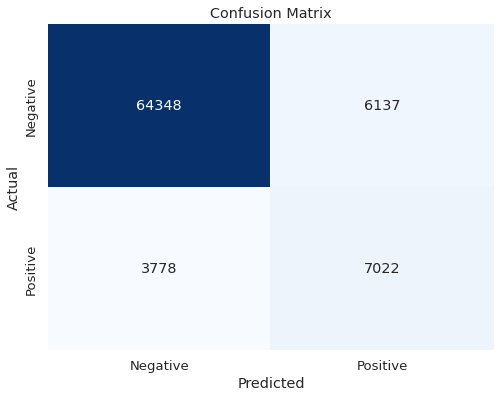

Accuracy: 0.8780217752352832
Precision: 0.5336271753172733
Recall: 0.6501851851851852
F1 Score: 0.5861680370633164


In [8]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/heatmap only/22_checkpoint14.csv')
visualize_val(test_results)

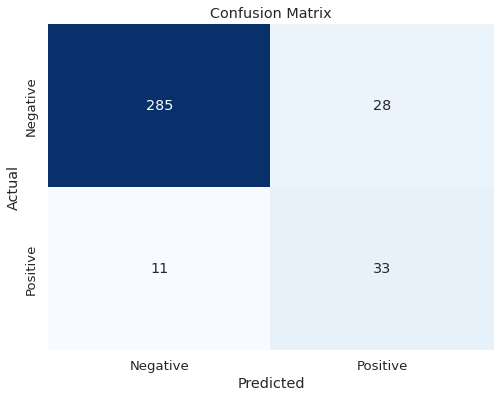

Accuracy: 0.8907563025210085
Precision: 0.5409836065573771
Recall: 0.75
F1 Score: 0.6285714285714287


In [11]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/heatmap only/23_checkpoint12_357samples.csv')
visualize_val(test_results)

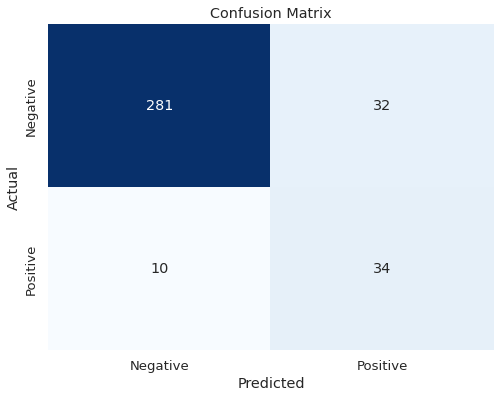

Accuracy: 0.8823529411764706
Precision: 0.5151515151515151
Recall: 0.7727272727272727
F1 Score: 0.6181818181818182


In [12]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/heatmap only/24_checkpoint5_357samples.csv')
visualize_val(test_results)

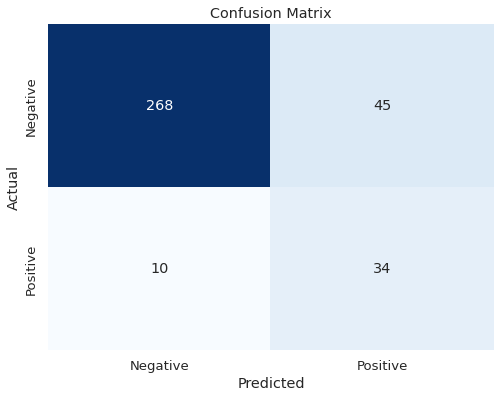

Accuracy: 0.84593837535014
Precision: 0.43037974683544306
Recall: 0.7727272727272727
F1 Score: 0.5528455284552845


In [14]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/heatmap only/25_checkpoint4_357samples.csv')
visualize_val(test_results)

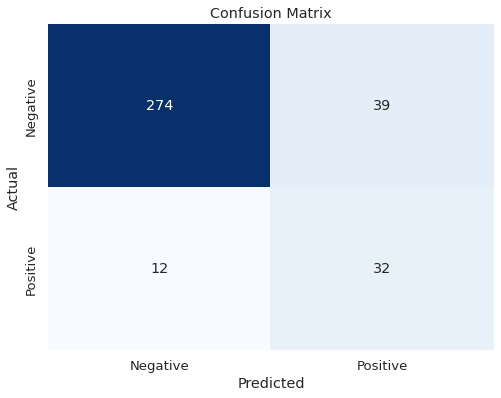

Accuracy: 0.8571428571428571
Precision: 0.4507042253521127
Recall: 0.7272727272727273
F1 Score: 0.5565217391304348


In [15]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/heatmap only/26_checkpoint35_357samples.csv')
visualize_val(test_results)

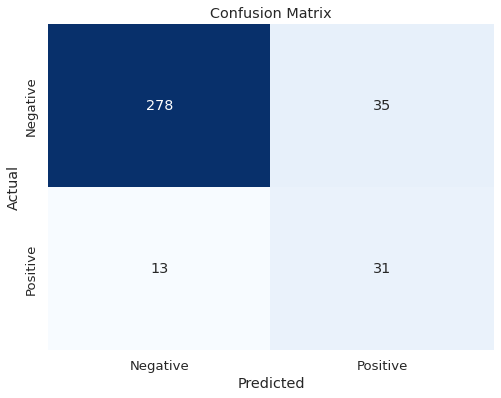

Accuracy: 0.865546218487395
Precision: 0.4696969696969697
Recall: 0.7045454545454546
F1 Score: 0.5636363636363637


In [16]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/heatmap only/27_checkpoint25_357samples.csv')
visualize_val(test_results)

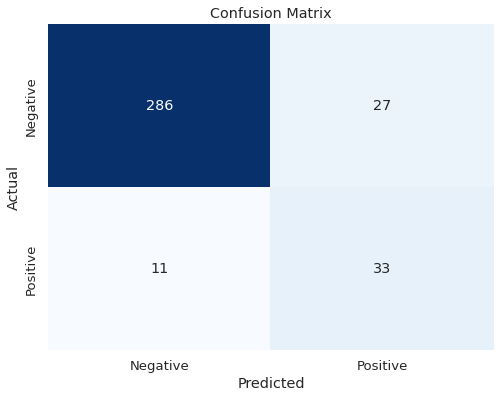

Accuracy: 0.8935574229691877
Precision: 0.55
Recall: 0.75
F1 Score: 0.6346153846153847


In [17]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/heatmap only/28_checkpoint24_357samples.csv')
visualize_val(test_results)

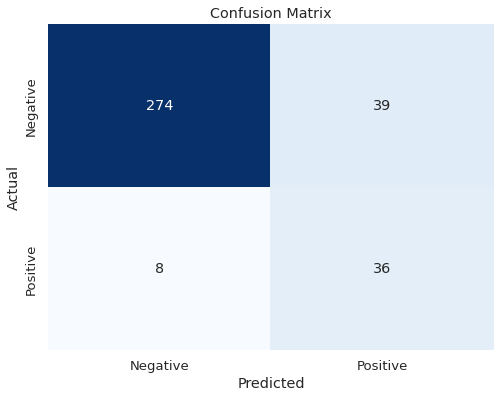

Accuracy: 0.8683473389355743
Precision: 0.48
Recall: 0.8181818181818182
F1 Score: 0.6050420168067226


In [18]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/20_checkpoint4_357samples.csv')
visualize_val(test_results)

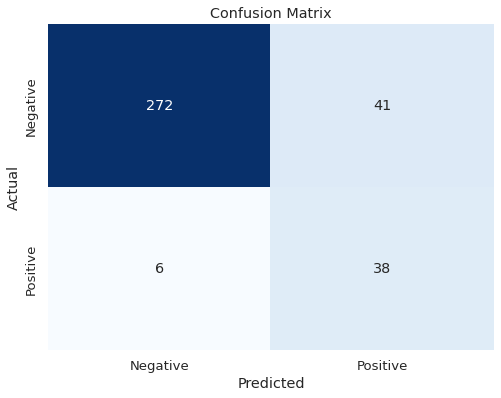

Accuracy: 0.8683473389355743
Precision: 0.4810126582278481
Recall: 0.8636363636363636
F1 Score: 0.6178861788617886


In [19]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/21_checkpoint4_357samples.csv')
visualize_val(test_results)

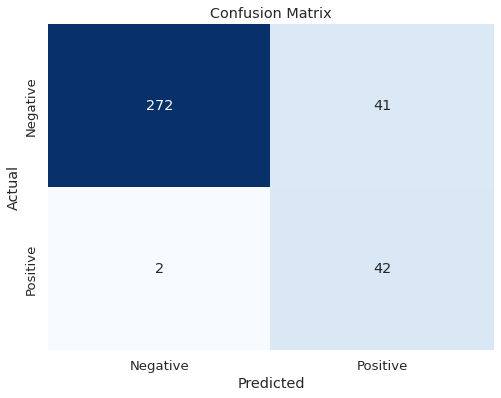

Accuracy: 0.8795518207282913
Precision: 0.5060240963855421
Recall: 0.9545454545454546
F1 Score: 0.6614173228346456


In [20]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/22_checkpoint4_357samples.csv')
visualize_val(test_results)

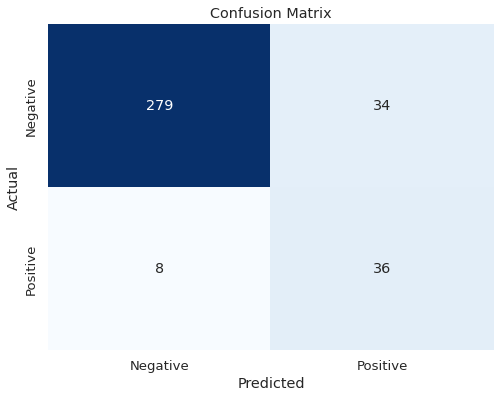

Accuracy: 0.8823529411764706
Precision: 0.5142857142857142
Recall: 0.8181818181818182
F1 Score: 0.6315789473684209


In [21]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/23_checkpoint20_357samples.csv')
visualize_val(test_results)

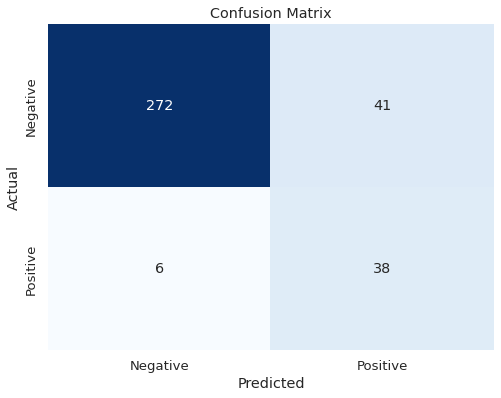

Accuracy: 0.8683473389355743
Precision: 0.4810126582278481
Recall: 0.8636363636363636
F1 Score: 0.6178861788617886


In [23]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/24_checkpoint5_357samples.csv')
visualize_val(test_results)

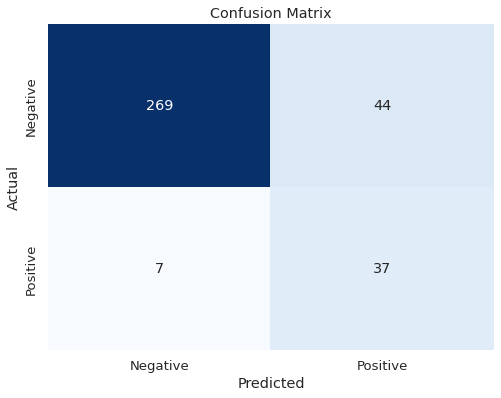

Accuracy: 0.8571428571428571
Precision: 0.4567901234567901
Recall: 0.8409090909090909
F1 Score: 0.592


In [24]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/25_checkpoint5_357samples.csv')
visualize_val(test_results)

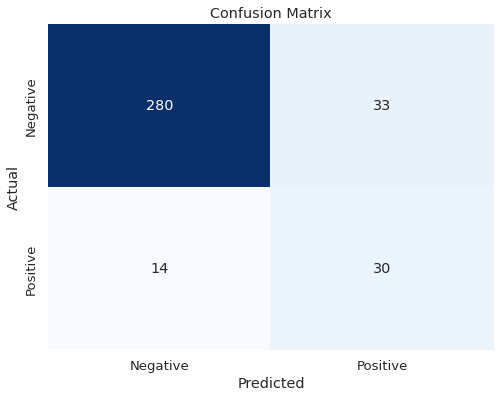

Accuracy: 0.8683473389355743
Precision: 0.47619047619047616
Recall: 0.6818181818181818
F1 Score: 0.5607476635514018


In [25]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/26_checkpoint35_357samples.csv')
visualize_val(test_results)

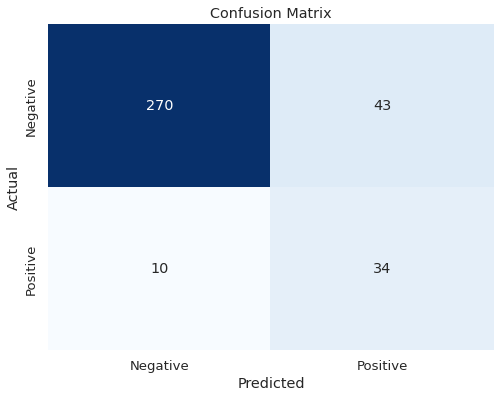

Accuracy: 0.8515406162464986
Precision: 0.44155844155844154
Recall: 0.7727272727272727
F1 Score: 0.5619834710743802


In [26]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/27_checkpoint25_357samples.csv')
visualize_val(test_results)

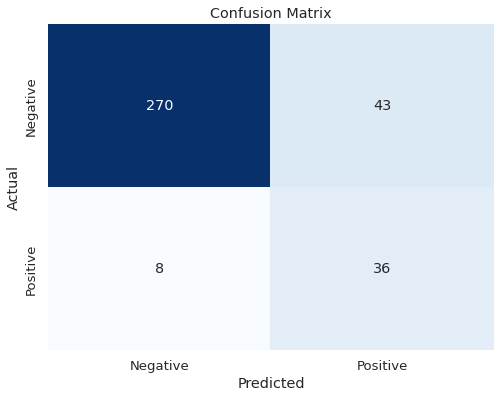

Accuracy: 0.8571428571428571
Precision: 0.45569620253164556
Recall: 0.8181818181818182
F1 Score: 0.5853658536585367


In [27]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text+heatmap2/28_checkpoint25_357samples.csv')
visualize_val(test_results)

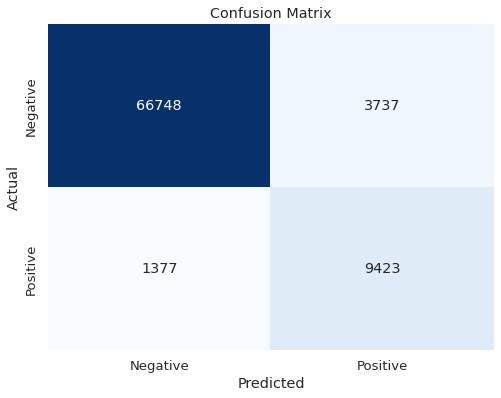

Accuracy: 0.9370855631420312
Precision: 0.7160334346504559
Recall: 0.8725
F1 Score: 0.7865609348914857


In [6]:
test_results = pd.read_csv('/work/adapting-CLIP-VGPs/checkpoints/text_only/01_checkpoint8.csv')
visualize_val(test_results)